# DQN Agent - Heuristic reward

In [1]:
import os
while os.path.basename(os.getcwd()) != "MountainCar-RL":
    os.chdir('..')

import gymnasium as gym

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from agents.DQN_agent import DQNAgent

from agents.MLP import QNetwork
from agents.data_processing import *

## Agent training

In [2]:
seed = 101

torch.manual_seed(seed + 2)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed + 3)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Create env
max_episode_steps=200
env = gym.make('MountainCar-v0', max_episode_steps=max_episode_steps)

# Create agent
action_space = np.array([0, 1, 2])
action_space_size = action_space.size
state_size = 2

# Set up torch device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on {device}")

# Create MLP
hidden_dims = [64] * 2
act = F.sigmoid
Q = QNetwork(state_size, action_space_size, hidden_dims, act=act)

# Setup hyperparameters
eps_max = 0.9
eps_min = 0.05
t_at_capacity = 100000  # number of iterations before reaching eps_min (e^-5 =~ 0)
eps = lambda t : eps_min + (eps_max - eps_min) * math.exp(-t * 5. / t_at_capacity)

gamma = 0.99
buffer_size = 10000
batch_size = 64
start_sampling = 1000

# Setup optimizer
lr = 0.001
weight_decay = 0.01
optimizer = optim.AdamW(Q.parameters(), lr=lr, weight_decay=weight_decay)

agent = DQNAgent(action_space, Q, optimizer,
                 gamma=gamma, eps=eps, buffer_size=buffer_size, batch_size=batch_size, start_sampling=start_sampling,
                 device=device, random_seed=seed)

Running on cpu


In [3]:
E = lambda state: 0.5*state[1]**2 + (1./2)*0.0025*np.sin(3*state[0])
heuristic_reward = lambda old_state, new_state: 15_000 * (E(new_state) - E(old_state))

n_episodes = 3000

episode_seeds = np.zeros(n_episodes, dtype=int)
initial_xs = np.zeros(n_episodes, dtype=float)
durations = np.zeros(n_episodes, dtype=int)
losses = np.zeros(n_episodes, dtype=float)
env_rewards = np.zeros(n_episodes, dtype=float)
heu_rewards = np.zeros(n_episodes, dtype=float)
rewards = np.zeros(n_episodes, dtype=float)

losses_steps = []

rng_seed = np.random.default_rng(seed + 1)
for episode in range(n_episodes):
    episode_seed = rng_seed.integers(2147483647).item()
    episode_seeds[episode] = episode_seed
    
    state, _ = env.reset(seed=episode_seed)
    done = False

    initial_xs[episode] = state[0].item()
    
    episode_env_reward = 0
    episode_heu_reward = 0
    episode_reward = 0
    episode_loss = 0
    episode_steps = 0
    
    while not done:
        action = agent.select_action(state)
        next_state, env_reward, terminated, truncated, _ = env.step(action)

        heu_reward = heuristic_reward(state, next_state)
        reward = env_reward + heu_reward
        
        agent.observe(state, action, next_state, reward)
        loss = agent.update()

        state = next_state
        done = terminated or truncated

        episode_env_reward += env_reward
        episode_heu_reward += heu_reward
        episode_reward += reward
        episode_steps += 1
        episode_loss += loss if loss is not None else 0

        losses_steps.append(loss if loss is not None else 0)
    
    print(f"Episode: {episode}, Reward: {episode_reward: .4f}, Loss: {episode_loss/episode_steps: .2e}, Steps: {episode_steps}, epsilon: {agent.eps(agent.updates_counter): .4f}")

    durations[episode] = episode_steps
    losses[episode] = episode_loss/episode_steps
    env_rewards[episode] = episode_env_reward
    heu_rewards[episode] = episode_heu_reward
    rewards[episode] = episode_reward

losses_steps = np.array(losses_steps)

Episode: 0, Reward: -200.3599, Loss:  0.00e+00, Steps: 200, epsilon:  0.8915
Episode: 1, Reward: -197.1446, Loss:  0.00e+00, Steps: 200, epsilon:  0.8832
Episode: 2, Reward: -199.3212, Loss:  0.00e+00, Steps: 200, epsilon:  0.8749
Episode: 3, Reward: -199.9324, Loss:  0.00e+00, Steps: 200, epsilon:  0.8667
Episode: 4, Reward: -196.2268, Loss:  2.74e-03, Steps: 200, epsilon:  0.8585
Episode: 5, Reward: -197.7798, Loss:  5.44e-01, Steps: 200, epsilon:  0.8505
Episode: 6, Reward: -199.4719, Loss:  3.97e-01, Steps: 200, epsilon:  0.8425
Episode: 7, Reward: -198.2675, Loss:  2.76e-01, Steps: 200, epsilon:  0.8346
Episode: 8, Reward: -199.1452, Loss:  1.99e-01, Steps: 200, epsilon:  0.8268
Episode: 9, Reward: -198.7002, Loss:  1.43e-01, Steps: 200, epsilon:  0.8191
Episode: 10, Reward: -199.6164, Loss:  9.70e-02, Steps: 200, epsilon:  0.8115
Episode: 11, Reward: -199.8337, Loss:  6.61e-02, Steps: 200, epsilon:  0.8039
Episode: 12, Reward: -199.8955, Loss:  4.19e-02, Steps: 200, epsilon:  0.7

**OPTIONAL: save results**

In [3]:
data = {
    'seed': episode_seeds,
    'initial_x': initial_xs,
    'env_reward': env_rewards,
    'other_reward': heu_rewards,
    'reward': rewards,
    'duration': durations,
    'loss': losses
}

df = pd.DataFrame(data)

"""
df.to_csv('results/C_train_DQN_heuristic.csv', index=False)

np.save("results/C_train_DQN_heuristic_lossesSteps", losses_steps)
"""

NameError: name 'episode_seeds' is not defined

## Plotting

**OPTIONAL: load results**

In [2]:
df = pd.read_csv('results/C_train_DQN_heuristic.csv')

n_episodes = len(df.index)

seeds = df['seed'].to_numpy()
initial_xs = df['initial_x'].to_numpy()
env_rewards = df['env_reward'].to_numpy()
heu_rewards = df['other_reward'].to_numpy()
rewards = df['reward'].to_numpy()
durations = df['duration'].to_numpy()
losses = df['loss'].to_numpy()

losses_steps = np.load("results/C_train_DQN_heuristic_lossesSteps.npy")

**PLOT: episodes duration**

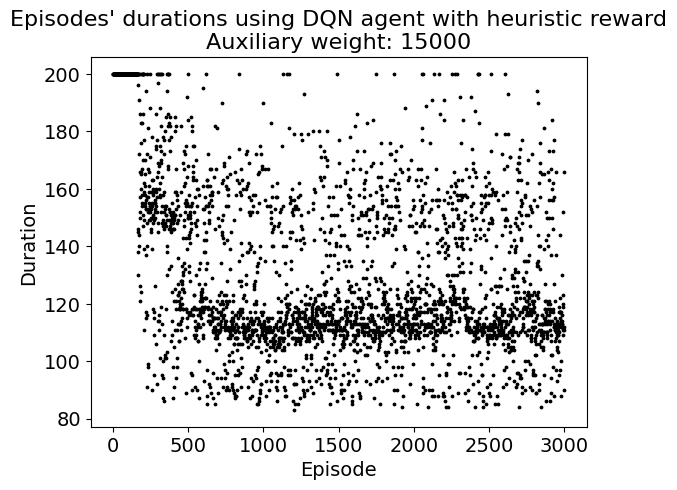

In [3]:
plt.scatter(range(n_episodes), durations, s=3, c='black', rasterized=True)
plt.ylabel("Duration", fontsize=14)
plt.xlabel("Episode", fontsize=14)
plt.tick_params(axis='both', labelsize=14)
plt.title("Episodes' durations using DQN agent with heuristic reward\nAuxiliary weight: 15000", fontsize=16)
plt.savefig("plots/C_DQN_heuristic_duration.pdf", transparent=True, bbox_inches="tight", dpi=400)
plt.show()

**PLOT: accumulated reward per episode**

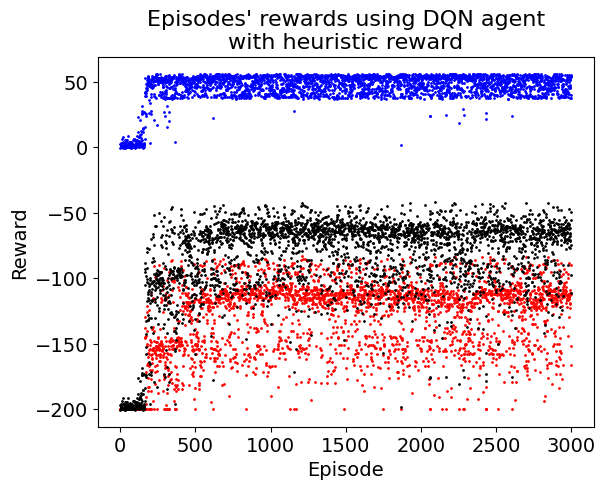

In [5]:
plt.scatter(range(n_episodes), env_rewards, s=1, c='red', label="Environment reward", rasterized=True)
plt.scatter(range(n_episodes), heu_rewards, s=1, c='#0000ff', label="Heuristic reward", rasterized=True)
plt.scatter(range(n_episodes), rewards, s=1, c='black', label="Total reward", rasterized=True)
plt.ylabel("Reward", fontsize=14)
plt.xlabel("Episode", fontsize=14)
plt.tick_params(axis='both', labelsize=14)
plt.title("Episodes' rewards using DQN agent\nwith heuristic reward", fontsize=16)
plt.savefig("plots/C_DQN_heuristic_reward.pdf", transparent=True, bbox_inches="tight", dpi=400)
plt.show()

**PLOT: accumulated reward per episode (moving average)**

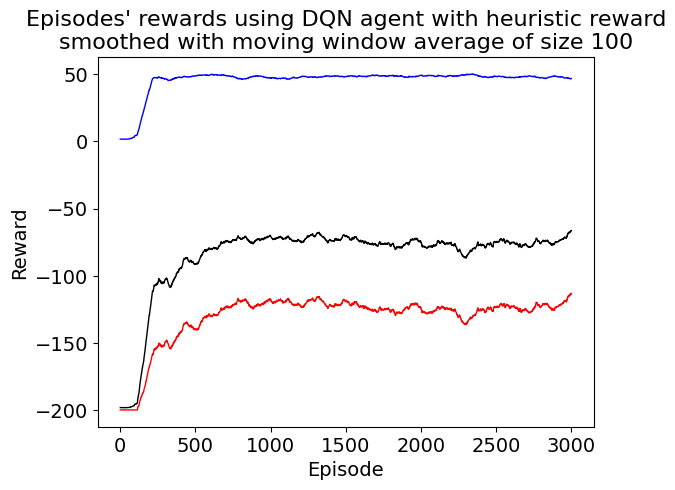

In [19]:
window_size = 100
plot_interval = 1
mask = [plot_interval*i for i in range(n_episodes//plot_interval)] + [n_episodes-1]

plt.plot(np.array(list(range(n_episodes)))[mask], moving_window_average(env_rewards, window_size)[mask], '-', c='red', label="Environment reward", linewidth=1, rasterized=True)
plt.plot(np.array(list(range(n_episodes)))[mask], moving_window_average(heu_rewards, window_size)[mask], '-', c='#0000ff', label="Heuristic reward", linewidth=1, rasterized=True)
plt.plot(np.array(list(range(n_episodes)))[mask], moving_window_average(rewards, window_size)[mask], '-', c='black', label="Total reward", linewidth=1, rasterized=True)
plt.ylabel("Reward", fontsize=14)
plt.xlabel("Episode", fontsize=14)
plt.tick_params(axis='both', labelsize=14)
plt.title(f"Episodes' rewards using DQN agent with heuristic reward\nsmoothed with moving window average of size {window_size}", fontsize=16)
plt.savefig("plots/C_DQN_heuristic_reward_avg.pdf", transparent=True, bbox_inches="tight", dpi=400)
plt.show()

**PLOT: accumulated reward per episode (normalized)**

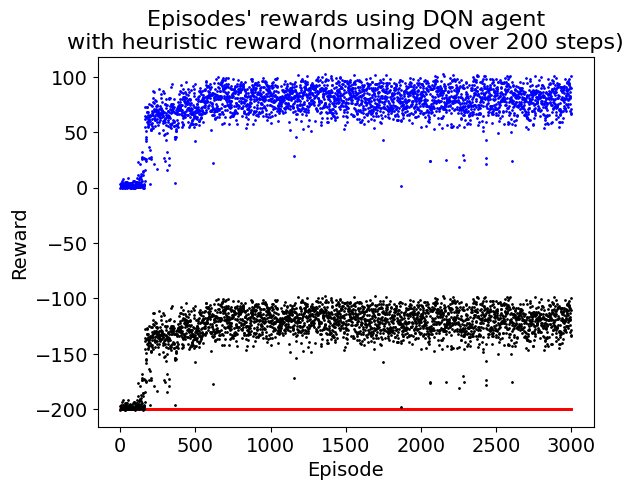

In [9]:
plt.scatter(range(n_episodes), 200*env_rewards/durations, s=1, c='red', label="Environment reward", rasterized=True)
plt.scatter(range(n_episodes), 200*heu_rewards/durations, s=1, c='#0000ff', label="Heuristic reward", rasterized=True)
plt.scatter(range(n_episodes), 200*rewards/durations, s=1, c='black', label="Total reward", rasterized=True)
plt.ylabel("Reward", fontsize=14)
plt.xlabel("Episode", fontsize=14)
plt.tick_params(axis='both', labelsize=14)
plt.title("Episodes' rewards using DQN agent\nwith heuristic reward (normalized over 200 steps)", fontsize=16)
plt.savefig("plots/C_DQN_heuristic_rewardNormalized.pdf", transparent=True, bbox_inches="tight", dpi=400)
plt.show()

**PLOT: cumulative reward over episodes**

separately depict the environment reward, the auxiliary reward and their sum.

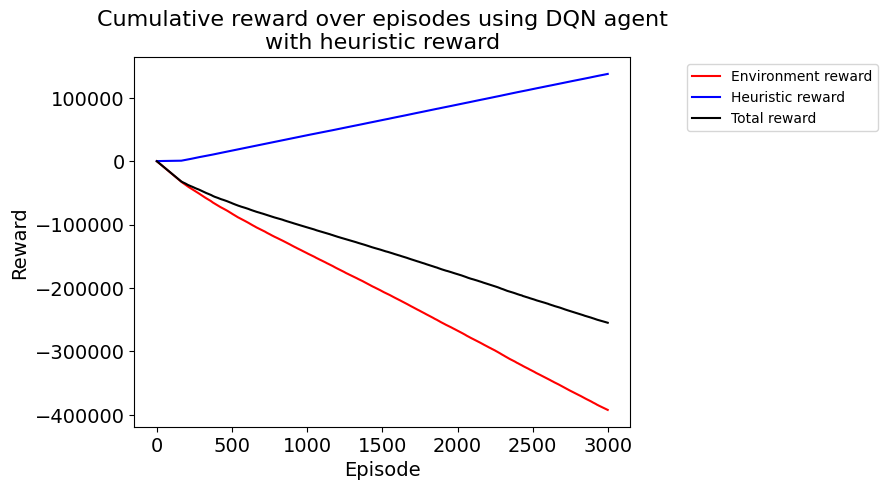

In [10]:
cum_env_rewards = env_rewards.cumsum()
cum_heu_rewards = heu_rewards.cumsum()
cum_rewards = rewards.cumsum()

plt.plot(range(n_episodes), cum_env_rewards, '-', c='red', label="Environment reward", rasterized=True)
plt.plot(range(n_episodes), cum_heu_rewards, '-', c='#0000ff', label="Heuristic reward", rasterized=True)
plt.plot(range(n_episodes), cum_rewards, '-', c='black', label="Total reward", rasterized=True)
plt.ylabel("Reward", fontsize=14)
plt.xlabel("Episode", fontsize=14)
plt.tick_params(axis='both', labelsize=14)
plt.title("Cumulative reward over episodes using DQN agent\nwith heuristic reward", fontsize=16)
plt.legend(bbox_to_anchor=(1.1, 1), markerscale=3)
plt.savefig("plots/C_DQN_heuristic_cumulativeReward.pdf", transparent=True, bbox_inches="tight", dpi=400)
plt.show()

**PLOT: Cumulative number of successes**

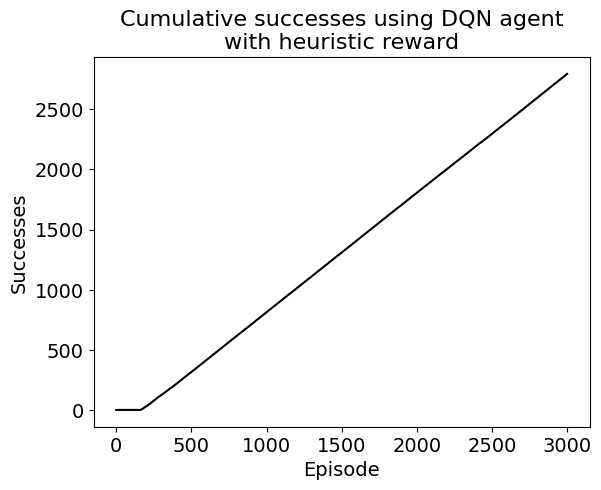

In [12]:
cum_successes = np.array([(1 if d < 200 else 0) for d in durations]).cumsum()

plt.plot(range(n_episodes), cum_successes, '-', c='black', rasterized=True)
plt.ylabel("Successes", fontsize=14)
plt.xlabel("Episode", fontsize=14)
plt.tick_params(axis='both', labelsize=14)
plt.title("Cumulative successes using DQN agent\nwith heuristic reward", fontsize=16)
plt.savefig("plots/C_DQN_heuristic_cumulativeSuccesses.pdf", transparent=True, bbox_inches="tight", dpi=400)
plt.show()

**PLOT: Training loss**

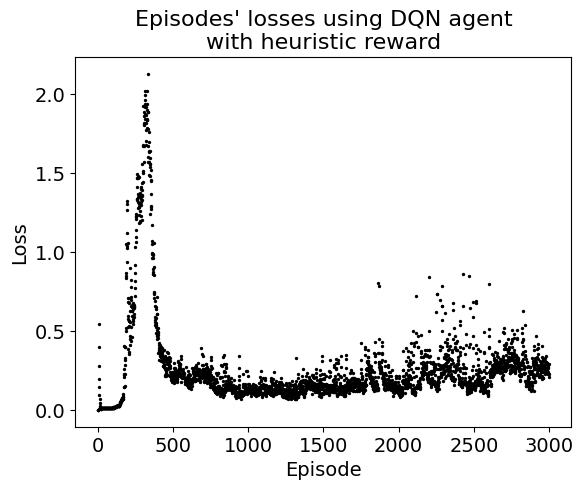

In [14]:
plt.scatter(range(n_episodes), losses, s=2, c='black', rasterized=True)
plt.ylabel("Loss", fontsize=14)
plt.xlabel("Episode", fontsize=14)
plt.tick_params(axis='both', labelsize=14)
plt.title("Episodes' losses using DQN agent\nwith heuristic reward", fontsize=16)
plt.savefig("plots/C_DQN_heuristic_loss.pdf", transparent=True, bbox_inches="tight", dpi=400)
plt.show()

**PLOT: Training loss step-by-step**

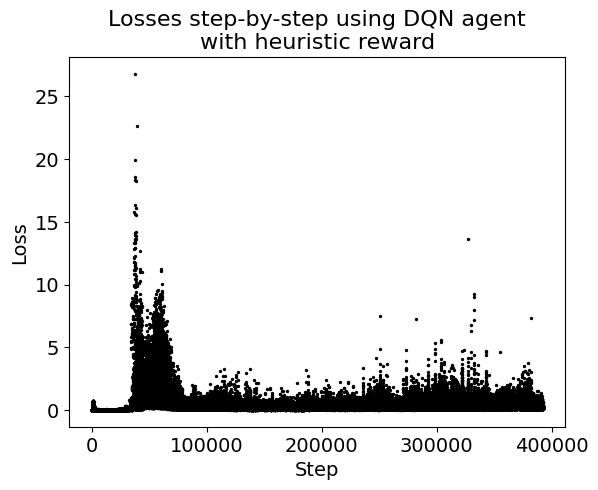

In [20]:
plt.scatter(range(losses_steps.size), losses_steps, s=2, c='black', rasterized=True)
plt.ylabel("Loss", fontsize=14)
plt.xlabel("Step", fontsize=14)
plt.tick_params(axis='both', labelsize=14)
plt.title("Losses step-by-step using DQN agent\nwith heuristic reward", fontsize=16)
plt.savefig("plots/C_DQN_heuristic_lossStep.pdf", transparent=True, bbox_inches="tight", dpi=400)
plt.show()

## Agent testing

In [13]:
seed = 42

E = lambda state: 0.5*state[1]**2 + (1./2)*0.0025*np.sin(3*state[0])
heuristic_reward = lambda old_state, new_state: 15_000 * (E(new_state) - E(old_state))

n_episodes = 1000

agent.eps = 0

episode_seeds = np.zeros(n_episodes, dtype=int)
initial_xs = np.zeros(n_episodes, dtype=float)
durations = np.zeros(n_episodes, dtype=int)
env_rewards = np.zeros(n_episodes, dtype=float)
heu_rewards = np.zeros(n_episodes, dtype=float)
rewards = np.zeros(n_episodes, dtype=float)

rng_seed = np.random.default_rng(seed)
for episode in range(n_episodes):
    episode_seed = rng_seed.integers(2147483647).item()
    episode_seeds[episode] = episode_seed
    
    state, _ = env.reset(seed=episode_seed)
    done = False

    initial_xs[episode] = state[0].item()
    
    episode_env_reward = 0
    episode_heu_reward = 0
    episode_reward = 0
    episode_steps = 0
    
    while not done:
        action = agent.select_action(state)
        next_state, env_reward, terminated, truncated, _ = env.step(action)

        heu_reward = heuristic_reward(state, next_state)
        reward = env_reward + heu_reward
        
        agent.observe(state, action, next_state, reward)
        # loss = agent.update()

        state = next_state
        done = terminated or truncated

        episode_env_reward += env_reward
        episode_heu_reward += heu_reward
        episode_reward += reward
        episode_steps += 1
        episode_loss += loss if loss is not None else 0
    
    print(f"Episode: {episode}, Reward: {episode_reward: .4f}, Steps: {episode_steps}, epsilon: {agent.eps(agent.updates_counter): .4f}")
    
    durations[episode] = episode_steps
    env_rewards[episode] = episode_env_reward
    heu_rewards[episode] = episode_heu_reward
    rewards[episode] = episode_reward

Episode: 0, Reward: -48.0080, Steps: 88, epsilon:  0.0000
Episode: 1, Reward: -57.8195, Steps: 114, epsilon:  0.0000
Episode: 2, Reward: -56.9832, Steps: 113, epsilon:  0.0000
Episode: 3, Reward: -61.1183, Steps: 116, epsilon:  0.0000
Episode: 4, Reward: -61.2741, Steps: 113, epsilon:  0.0000
Episode: 5, Reward: -62.7962, Steps: 109, epsilon:  0.0000
Episode: 6, Reward: -62.1484, Steps: 109, epsilon:  0.0000
Episode: 7, Reward: -57.1367, Steps: 113, epsilon:  0.0000
Episode: 8, Reward: -62.4744, Steps: 109, epsilon:  0.0000
Episode: 9, Reward: -58.8080, Steps: 115, epsilon:  0.0000
Episode: 10, Reward: -57.2026, Steps: 113, epsilon:  0.0000
Episode: 11, Reward: -49.4188, Steps: 89, epsilon:  0.0000
Episode: 12, Reward: -57.8300, Steps: 114, epsilon:  0.0000
Episode: 13, Reward: -57.1300, Steps: 113, epsilon:  0.0000
Episode: 14, Reward: -56.8724, Steps: 113, epsilon:  0.0000
Episode: 15, Reward: -45.4291, Steps: 86, epsilon:  0.0000
Episode: 16, Reward: -45.3014, Steps: 86, epsilon:  0

**Save results**

In [14]:
data = {
    'seed': episode_seeds,
    'initial_x': initial_xs,
    'env_reward': env_rewards,
    'other_reward': heu_rewards,
    'reward': rewards,
    'duration': durations
}

df = pd.DataFrame(data)

# df.to_csv('results/C_test_DQN_heuristic.csv', index=False)